<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Required Libraries and Modules</h2>
</div>

**Note: This notebook is run in Paperspace platform**

In [1]:
!pip install transformers
!pip install torch
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 23.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.2/763.2 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 24.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 23.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 188.1 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895261 sha256=d16cbf3f318220a44a2d2e9ad696edef69327be5dab98a2cd3a759e07af6934a
  Stored in directory: /tmp/pip-ephem-wheel-cache-n58bll7w/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 23.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 32.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback, set_seed

# Progress bar
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()

/tmp/ipykernel_52/491656687.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Import Clean Text Data</h2>
</div>

In [3]:
###############################################################
# Note: Change the name of data set used for feature creation
###############################################################
data_set='bully_data_clean_with_stopword'
    
    
###################
# Import Data Set #
###################
bully_data_cleaned = pd.read_csv('/datasets/data/bully_data_clean_with_stopword_short.csv', encoding='utf8')                                            
bully_data_cleaned = bully_data_cleaned[~bully_data_cleaned['text_check'].isna()]
bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['text_check'] != ""]
#bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['role']!='None']
bully_data_cleaned = bully_data_cleaned[['label','text_check']]
bully_data_cleaned['label'] = bully_data_cleaned['label'].progress_apply(lambda x: 1 if x =="Cyberbullying" else 0)
bully_data_cleaned.rename(columns = {'text_check':'text'}, inplace = True)
bully_data_cleaned = bully_data_cleaned.reset_index(drop=True)

  0%|          | 0/112247 [00:00<?, ?it/s]

In [4]:
bully_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112247 entries, 0 to 112246
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   112247 non-null  int64 
 1   text    112247 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [5]:
bully_data_cleaned['label'].value_counts()

0    106872
1      5375
Name: label, dtype: int64

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Define pretrained tokenizer and model</h2>
</div>

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Define pretrained tokenizer and model

model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained(model_name, 
#                                                               num_labels=2, 
#                                                             output_attentions = False, # Whether the model returns attentions weights.
#                                                             output_hidden_states = False,
#                                                             return_dict=True )
set_seed(1127)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Preprocess data and Fine Tune Transformers</h2>
</div>

In [7]:
##############################
# Data: Text Input and Label #
##############################
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])


########################
# Create torch dataset #
########################
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


#############################
# Define Trainer parameters #
#############################
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall_cb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    precision_cb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    f1_cb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    
    recall_ncb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    precision_ncb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    f1_ncb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    
    recall_overall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision_overall = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1_overall = f1_score(y_true=labels, y_pred=pred, average='macro')


    return {"accuracy": accuracy, 
            "precision_cb": precision_cb, "recall_cb": recall_cb, "f1_cb": f1_cb,
            "precision_ncb": precision_ncb, "recall_ncb": recall_ncb, "f1_ncb": f1_ncb,
            "precision_overall": precision_overall, "recall_overall": recall_overall, "f1_overall": f1_overall}


#########################
# Plot Confusion Matrix #
#########################
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CONFUSION MATRIX IN PERCENTAGE
    cf_pct = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf_pct.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf_pct,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


########################
# Run cross-validation #
########################
def run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=False):
    
    kfold = StratifiedShuffleSplit(n_splits=splits, test_size=0.1, random_state=1127)
    # kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1127)
    n_fold = 1

    print("Developing Model with Cross validation for: " + model_name)
    for train, test in tqdm(kfold.split(X, y)):

        print("Running for Fold: ",n_fold)
        train_index = list(train)
        test_index = list(test)

        X_train = [X[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        X_val = [X[i] for i in test_index]
        y_val = [y[i] for i in test_index]

        # Tokenize
        X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
        X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

        # Create torch dataset
        train_dataset = Dataset(X_train_tokenized, y_train)
        val_dataset = Dataset(X_val_tokenized, y_val)

        # Fine Tune Transformer
        # Define Trainer
        args = TrainingArguments(
            output_dir="content/drive/MyDrive_binary/output_" + model_name + "/fold"+str(n_fold),
            evaluation_strategy="epoch",
            save_strategy="epoch",
            #eval_steps=500,
            #per_device_train_batch_size=1,
            #per_device_eval_batch_size=1,
            num_train_epochs=epoch, #1 was okay
            seed=1127,
            load_best_model_at_end=True,
        )

        trainer = Trainer(
        # model_init=model_init,
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        )

        if n_fold <=4:
            checkpoint_temp=True
        else:
            checkpoint_temp=False
            
        trainer.train(resume_from_checkpoint=checkpoint)
        print("Complete for fold", n_fold)
        n_fold= n_fold + 1


#####################
# Run Hold Out Test #
#####################

# Train and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1127)

# Train and Validate Set
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_test)

def run_hold_out_split(model_name='DistilRoBerta',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False):
  
    print("Developing Model with Hold Out Splits for: " + model_name)
    # Fine Tune Transformer
    # Define Trainer
    args = TrainingArguments(
      output_dir="content/drive/MyDrive_binary/output_" + model_name + "/holdout",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      #eval_steps=500,
      #per_device_train_batch_size=1,
      #per_device_eval_batch_size=1,
      num_train_epochs=epoch, #1 was okay
      seed=1127,
      load_best_model_at_end=True,
    )

    trainer = Trainer(
    #model_init=model_init,
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    trainer.train(resume_from_checkpoint=checkpoint)
    print("Complete for hold-out validate set")


In [8]:
###########################
# Predict (Hold Out Test) #
###########################

from sklearn.metrics import confusion_matrix
def compute_metrics_holdout(model_name='DistilRoBerta',
                            model_path='content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-3820', 
                            average_method='binary',
                            X_test=X_test):
  
    X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    test_dataset = Dataset(X_test_tokenized)

    # Load trained model
    model_pred = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

    # Define test trainer
    test_trainer = Trainer(model_pred)

    # Make prediction
    raw_pred, _, _ = test_trainer.predict(test_dataset)

    # Preprocess raw predictions
    y_pred = np.argmax(raw_pred, axis=1)

    # Compute metrics
    precision_cb = precision_score(y_test, y_pred, average=average_method, pos_label=1)
    recall_cb = recall_score(y_test, y_pred, average=average_method, pos_label=1)
    f1_cb = f1_score(y_test, y_pred, average=average_method, pos_label=1)

    precision_ncb = precision_score(y_test, y_pred, average=average_method, pos_label=0)
    recall_ncb = recall_score(y_test, y_pred, average=average_method, pos_label=0)
    f1_ncb = f1_score(y_test, y_pred, average=average_method, pos_label=0)

    precision_overall = precision_score(y_test, y_pred, average='macro')
    recall_overall = recall_score(y_test, y_pred, average='macro')
    f1_overall = f1_score(y_test, y_pred, average='macro')

    # Print Results
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print()
    print("Label 1: Cyberbullying")
    print("Precision: ", precision_cb)
    print("Recall: ", recall_cb)
    print("F-measure: ", f1_cb)
    print()
    print("Label 0: Non-Cyberbullying")
    print("Precision: ", precision_ncb)
    print("Recall: ", recall_ncb)
    print("F-measure: ", f1_ncb)
    print()
    print("Macro Metrics")
    print("Precision: ", precision_overall)
    print("Recall: ", recall_overall)
    print("F-measure: ", f1_overall)
    print()

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test,y_pred)
    categories = ['Non-Cyberbullying', 'Cyberbullying']
    labels = ['True Negative','',
            '','True Positive']

    make_confusion_matrix(conf_mat, 
                        group_names=labels,
                        categories=categories, 
                        figsize=(8,5), 
                        cbar=True, 
                        title='Fine Tuned ' + model_name + ' for Cyberbullying Detection', 
                        cmap='YlGnBu', 
                        sum_stats=False)



<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Cross Validation (K = 5)</h2>
</div>

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.124800,0.148734,0.958307,0.571429,0.520446,0.544747,0.975966,0.980350,0.978153,0.773698,0.750398,0.761450
2,0.126100,0.140187,0.960445,0.592157,0.561338,0.576336,0.977975,0.980537,0.979254,0.785066,0.770938,0.777795
3,0.115200,0.119991,0.965345,0.705234,0.475836,0.568257,0.974038,0.989988,0.981948,0.839636,0.732912,0.775103
4,0.099100,0.138072,0.965523,0.701333,0.488848,0.576123,0.974654,0.989520,0.982031,0.837994,0.739184,0.779077


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-37884
Configuration saved in content/drive/MyDriv

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.124400,0.142850,0.968552,0.762040,0.500000,0.603816,0.975258,0.992140,0.983626,0.868649,0.746070,0.793721
2,0.124600,0.118428,0.967038,0.760870,0.455390,0.569767,0.973127,0.992795,0.982862,0.866998,0.724093,0.776315
3,0.113100,0.108597,0.968196,0.698031,0.592937,0.641206,0.979662,0.987087,0.983361,0.838846,0.790012,0.812283


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-37884
Configuration saved in content/drive/MyDriv

### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 50512
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the t

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-37884 (score: 0.11999106407165527).


Epoch,Training Loss,Validation Loss


1it [00:24, 24.03s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-37884).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip t

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
4,0.087800,0.123047,0.968107,0.723881,0.540892,0.619149,0.977178,0.989614,0.983357,0.850529,0.765253,0.801253


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-50512
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-50512/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-50512/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-37884 (score: 0.1085965633392334).
2it [44:43, 1574.42s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.121500,0.117590,0.971759,0.778338,0.574349,0.660963,0.978851,0.991766,0.985266,0.878594,0.783058,0.823114
2,0.105600,0.114522,0.970512,0.768831,0.550186,0.641387,0.977675,0.991672,0.984624,0.873253,0.770929,0.813005
3,0.100800,0.099680,0.971492,0.709615,0.685874,0.697543,0.984213,0.985871,0.985041,0.846914,0.835872,0.841292
4,0.083700,0.104276,0.972650,0.759551,0.628253,0.687691,0.981447,0.989988,0.985699,0.870499,0.809120,0.836695


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-37884
Configuration saved in content/drive/MyDriv

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.111800,0.132846,0.968909,0.752000,0.524164,0.617744,0.976406,0.991298,0.983795,0.864203,0.757731,0.800770
2,0.112700,0.096531,0.973452,0.733463,0.700743,0.716730,0.984969,0.987181,0.986073,0.859216,0.843962,0.851402


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-25256/pytorch_model.bin


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 50512
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the t

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-37884 (score: 0.11999106407165527).


Epoch,Training Loss,Validation Loss


1it [01:14, 74.78s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip t

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-37884 (score: 0.1085965633392334).


Epoch,Training Loss,Validation Loss


2it [02:27, 73.78s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip t

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-37884 (score: 0.09968040138483047).


Epoch,Training Loss,Validation Loss


3it [03:38, 72.55s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-25256).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512
  Continuing training from checkpoint, will skip t

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
3,0.100400,0.098761,0.976214,0.797802,0.674721,0.731118,0.983751,0.991391,0.987557,0.890777,0.833056,0.859337
4,0.084500,0.102015,0.975857,0.797327,0.665428,0.725431,0.983296,0.991485,0.987374,0.890312,0.828456,0.856402


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-37884
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-37884/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-37884/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-50512
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-50512/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-50512/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-25256 (score: 0.09653127938508987).
4

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50512


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.111500,0.104568,0.975323,0.793258,0.656134,0.718210,0.982839,0.991391,0.987096,0.888049,0.823763,0.852653
2,0.100300,0.108842,0.972561,0.710623,0.721190,0.715867,0.985954,0.985216,0.985585,0.848288,0.853203,0.850726
3,0.089400,0.111876,0.973898,0.734226,0.713755,0.723845,0.985610,0.986994,0.986301,0.859918,0.850374,0.855073


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-37884
Configuration saved in content/drive/MyDriv

### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 50512
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.085400,0.130438,0.966058,0.755700,0.431227,0.549112,0.971973,0.992982,0.982365,0.863837,0.712104,0.765739
6,0.090200,0.165461,0.965791,0.750000,0.429368,0.546099,0.971879,0.992795,0.982226,0.860939,0.711082,0.764162


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-75768/pytorch_model.bin


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-75768).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 6
  Continuing training from global step 75768
  Will skip the first 6 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
7,0.103500,0.155852,0.966236,0.701266,0.514870,0.593783,0.975900,0.988959,0.982386,0.838583,0.751914,0.788085


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-88396/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-88396/pytorch_model.bin


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-88396).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
8,0.072400,0.161018,0.965523,0.702413,0.486989,0.575192,0.974567,0.989614,0.982033,0.838490,0.738301,0.778612


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-37884 (score: 0.11999106407165527).
1it [45:09, 2709.20s/it]

Complete for fold 1
Running for Fold:  2


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 8
  Continuing training from global step 101024
  Will skip the first 8 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume th

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-37884 (score: 0.11999106407165527).


Epoch,Training Loss,Validation Loss


1it [00:24, 24.39s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.109000,0.109952,0.968552,0.750678,0.514870,0.610805,0.975958,0.991391,0.983614,0.863318,0.753131,0.797210
6,0.086700,0.127138,0.967572,0.700461,0.565056,0.625514,0.978315,0.987836,0.983052,0.839388,0.776446,0.804283


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-75768/pytorch_model.bin


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=6,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75768
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 8
  Continuing training from global step 101024
  Will skip the first 8 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-37884 (score: 0.11999106407165527).


Epoch,Training Loss,Validation Loss


1it [00:25, 25.05s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-75768).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75768
  Continuing training from checkpoint, will skip t

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-37884 (score: 0.1085965633392334).


Epoch,Training Loss,Validation Loss


2it [00:46, 23.05s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75768
  Continuing training from checkpoint, will skip t

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.089700,0.107512,0.971403,0.765281,0.581784,0.661035,0.979197,0.991017,0.985072,0.872239,0.786401,0.823053
6,0.073700,0.109592,0.972205,0.760369,0.613383,0.679012,0.980725,0.990269,0.985474,0.870547,0.801826,0.832243


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-75768/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-37884 (score: 0.09968040138483047).
3

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-50512).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75768
  Continuing training from checkpoint, will skip t

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
5,0.089100,0.113113,0.973719,0.813953,0.585502,0.681081,0.979424,0.993263,0.986295,0.896689,0.789382,0.833688
6,0.085100,0.109332,0.974521,0.775109,0.659851,0.712851,0.983004,0.990362,0.986669,0.879056,0.825107,0.849760


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-63140/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-75768/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-25256 (score: 0.09653127938508987).
4

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-37884).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 75768
  Continuing training from checkpoint, will skip t

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
4,0.086300,0.107174,0.974343,0.751004,0.695167,0.722008,0.984711,0.988397,0.986551,0.867858,0.841782,0.854279
5,0.063500,0.112143,0.974432,0.752515,0.695167,0.722705,0.984713,0.988491,0.986598,0.868614,0.841829,0.854652


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-50512
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-50512/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-50512/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-63140
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-63140/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-63140/pytorch_model.bin


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 8
  Continuing training from global step 101024
  Will skip the first 8 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume th

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-37884 (score: 0.11999106407165527).


Epoch,Training Loss,Validation Loss


1it [00:23, 23.46s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-75768).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
7,0.081600,0.148243,0.967216,0.698598,0.555762,0.619048,0.977864,0.987929,0.982871,0.838231,0.771846,0.800959
8,0.089100,0.141397,0.967572,0.725389,0.520446,0.606061,0.976197,0.990081,0.983090,0.850793,0.755264,0.794575


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-88396/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-88396/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-37884 (score: 0.1085965633392334).

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-75768).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
7,0.074500,0.101698,0.972918,0.778571,0.607807,0.682672,0.980472,0.991298,0.985855,0.879522,0.799552,0.834264
8,0.084100,0.112745,0.972561,0.761364,0.622677,0.685072,0.981178,0.990175,0.985656,0.871271,0.806426,0.835364


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-88396/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-88396/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-37884 (score: 0.09968040138483047)

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-75768).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
7,0.067200,0.106050,0.975412,0.791111,0.661710,0.720648,0.983109,0.991204,0.987140,0.887110,0.826457,0.853894
8,0.070300,0.108017,0.975768,0.796875,0.663569,0.724138,0.983205,0.991485,0.987328,0.890040,0.827527,0.855733


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-88396/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-88396/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-25256 (score: 0.09653127938508987)

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-63140).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
6,0.064000,0.106314,0.975590,0.800000,0.654275,0.719836,0.982754,0.991766,0.987239,0.891377,0.823020,0.853538


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-75768
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-75768/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-75768/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1


Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 8
  Continuing training from global step 101024
  Will skip the first 8 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume th

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold1/checkpoint-37884 (score: 0.11999106407165527).


Epoch,Training Loss,Validation Loss


1it [01:19, 79.61s/it]

Complete for fold 1
Running for Fold:  2


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold2/checkpoint-37884 (score: 0.1085965633392334).


Epoch,Training Loss,Validation Loss


2it [02:34, 76.56s/it]

Complete for fold 2
Running for Fold:  3


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold3/checkpoint-37884 (score: 0.09968040138483047).


Epoch,Training Loss,Validation Loss


3it [03:45, 74.12s/it]

Complete for fold 3
Running for Fold:  4


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-101024).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold4/checkpoint-25256 (score: 0.09653127938508987).


Epoch,Training Loss,Validation Loss


4it [04:57, 73.31s/it]

Complete for fold 4
Running for Fold:  5


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-75768).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
7,0.047600,0.121929,0.974610,0.769723,0.671004,0.716981,0.983544,0.989894,0.986709,0.876633,0.830449,0.851845
8,0.070000,0.117399,0.974967,0.795402,0.643123,0.711202,0.982206,0.991672,0.986916,0.888804,0.817397,0.849059


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-88396
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-88396/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-88396/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/fold5/checkpoint-12628 (score: 0.10456773638725281)

Complete for fold 5


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Hold Out Split</h2>
</div>

In [ ]:
run_hold_out_split(model_name='DistilRoBerta',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024


Developing Model with Hold Out Splits for: DistilRoBerta


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.094700,0.131048,0.972650,0.766744,0.617100,0.683831,0.980912,0.990549,0.985707,0.873828,0.803825,0.834769
2,0.099600,0.123944,0.970780,0.736486,0.607807,0.665988,0.980429,0.989052,0.984721,0.858458,0.798429,0.825355
3,0.094300,0.108614,0.972205,0.731557,0.663569,0.695906,0.983142,0.987742,0.985437,0.857350,0.825655,0.840672
4,0.075200,0.115360,0.973541,0.814621,0.579926,0.677524,0.979155,0.993356,0.986205,0.896888,0.786641,0.831865
5,0.062900,0.122476,0.973898,0.793765,0.615242,0.693194,0.980848,0.991953,0.986369,0.887306,0.803597,0.839781
6,0.056800,0.141705,0.973007,0.811671,0.568773,0.668852,0.978614,0.993356,0.985930,0.895142,0.781065,0.827391
7,0.075000,0.125842,0.973363,0.783848,0.613383,0.688217,0.980748,0.991485,0.986087,0.882298,0.802434,0.837152


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-12628
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-12628/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-12628/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-25256
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-25256/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-25256/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-37884
Configuration saved in conten

In [9]:
run_hold_out_split(model_name='DistilRoBerta',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

Developing Model with Hold Out Splits for: DistilRoBerta


Loading model from content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-88396).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101022
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 101024
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 7
  Continuing training from global step 88396
  Will skip the first 7 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume th

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
8,0.059100,0.134102,0.973096,0.789216,0.598513,0.680761,0.980031,0.991953,0.985956,0.884624,0.795233,0.833359


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-101024
Configuration saved in content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-101024/config.json
Model weights saved in content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-101024/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-37884 (score: 0.10861410945653915).


Complete for hold-out validate set


### Test Split Cross Validation

#### Epoch 1

loading configuration file content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-12628/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-12628",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file content/drive/MyDrive_binary/output_Disti

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.77      0.62      0.68       538

    accuracy                           0.97     11225
   macro avg       0.87      0.80      0.83     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.766743648960739
Recall:  0.6171003717472119
F-measure:  0.6838311019567457

Label 0: Non-Cyberbullying
Precision:  0.9809117865085248
Recall:  0.9905492654627117
F-measure:  0.9857069695982121

Macro Metrics
Precision:  0.8738277177346319
Recall:  0.8038248186049618
F-measure:  0.8347690357774789



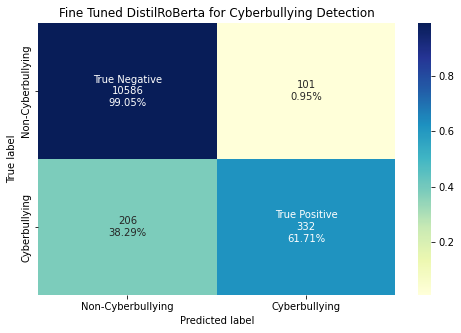

In [10]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-12628', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 2

loading configuration file content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-25256/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-25256",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file content/drive/MyDrive_binary/output_Disti

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10687
           1       0.74      0.61      0.67       538

    accuracy                           0.97     11225
   macro avg       0.86      0.80      0.83     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7364864864864865
Recall:  0.6078066914498141
F-measure:  0.6659877800407331

Label 0: Non-Cyberbullying
Precision:  0.9804285316760968
Recall:  0.9890521193973987
F-measure:  0.9847214458729271

Macro Metrics
Precision:  0.8584575090812916
Recall:  0.7984294054236064
F-measure:  0.8253546129568301



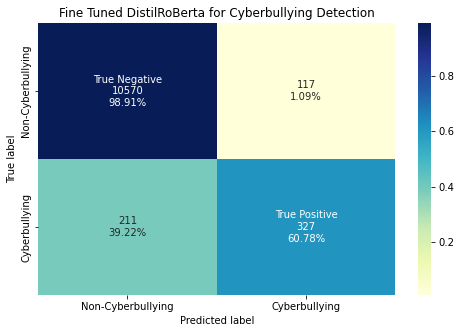

In [12]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-25256', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 3

loading configuration file content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-37884/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-37884",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file content/drive/MyDrive_binary/output_Disti

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.73      0.66      0.70       538

    accuracy                           0.97     11225
   macro avg       0.86      0.83      0.84     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7315573770491803
Recall:  0.6635687732342007
F-measure:  0.6959064327485379

Label 0: Non-Cyberbullying
Precision:  0.9831424047685573
Recall:  0.9877421165902498
F-measure:  0.9854368932038835

Macro Metrics
Precision:  0.8573498909088688
Recall:  0.8256554449122253
F-measure:  0.8406716629762108



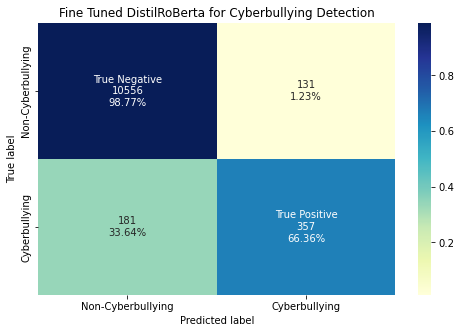

In [13]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-37884', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 4

loading configuration file content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-50512/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-50512",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file content/drive/MyDrive_binary/output_Disti

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.81      0.58      0.68       538

    accuracy                           0.97     11225
   macro avg       0.90      0.79      0.83     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.814621409921671
Recall:  0.5799256505576208
F-measure:  0.6775244299674267

Label 0: Non-Cyberbullying
Precision:  0.9791551374285187
Recall:  0.9933564143351735
F-measure:  0.9862046541873751

Macro Metrics
Precision:  0.8968882736750948
Recall:  0.7866410324463972
F-measure:  0.8318645420774009



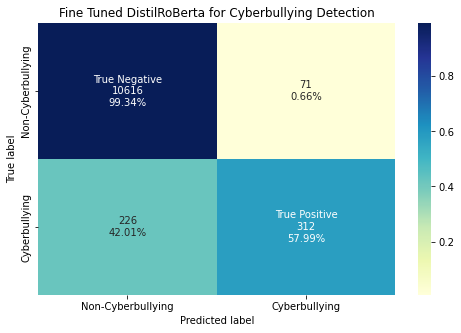

In [14]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-50512', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 5

loading configuration file content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-63140/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-63140",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file content/drive/MyDrive_binary/output_Disti

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.79      0.62      0.69       538

    accuracy                           0.97     11225
   macro avg       0.89      0.80      0.84     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7937649880095923
Recall:  0.6152416356877324
F-measure:  0.6931937172774869

Label 0: Non-Cyberbullying
Precision:  0.9808475203552923
Recall:  0.9919528398989427
F-measure:  0.9863689230053501

Macro Metrics
Precision:  0.8873062541824424
Recall:  0.8035972377933376
F-measure:  0.8397813201414185



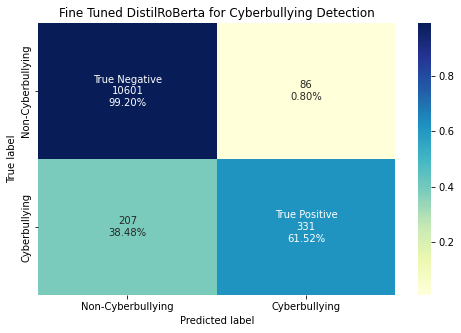

In [15]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-63140', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 6

loading configuration file content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-75768/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-75768",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file content/drive/MyDrive_binary/output_Disti

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.81      0.57      0.67       538

    accuracy                           0.97     11225
   macro avg       0.90      0.78      0.83     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.8116710875331565
Recall:  0.5687732342007435
F-measure:  0.6688524590163935

Label 0: Non-Cyberbullying
Precision:  0.9786135693215339
Recall:  0.9933564143351735
F-measure:  0.9859298815881123

Macro Metrics
Precision:  0.8951423284273452
Recall:  0.7810648242679585
F-measure:  0.827391170302253



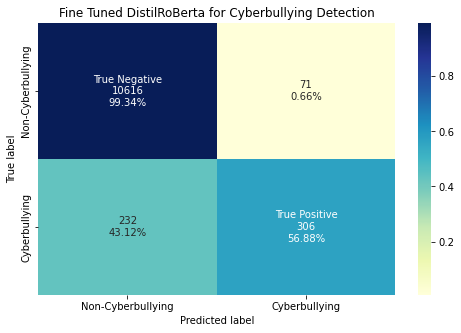

In [16]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-75768', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 7

loading configuration file content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-88396/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-88396",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file content/drive/MyDrive_binary/output_Disti

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.78      0.61      0.69       538

    accuracy                           0.97     11225
   macro avg       0.88      0.80      0.84     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7838479809976246
Recall:  0.6133828996282528
F-measure:  0.6882168925964546

Label 0: Non-Cyberbullying
Precision:  0.9807478711588301
Recall:  0.9914849817535323
F-measure:  0.986087199292727

Macro Metrics
Precision:  0.8822979260782273
Recall:  0.8024339406908925
F-measure:  0.8371520459445908



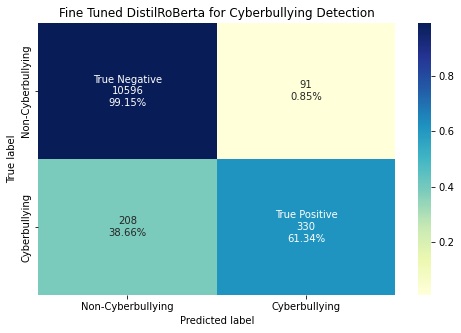

In [17]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-88396', 
                        average_method='binary',
                        X_test=X_test)

#### Epoch 8

loading configuration file content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-101024/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-101024",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file content/drive/MyDrive_binary/output_Dis

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.79      0.60      0.68       538

    accuracy                           0.97     11225
   macro avg       0.88      0.80      0.83     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7892156862745098
Recall:  0.5985130111524164
F-measure:  0.6807610993657506

Label 0: Non-Cyberbullying
Precision:  0.9800314320051771
Recall:  0.9919528398989427
F-measure:  0.9859561011904763

Macro Metrics
Precision:  0.8846235591398435
Recall:  0.7952329255256796
F-measure:  0.8333586002781135



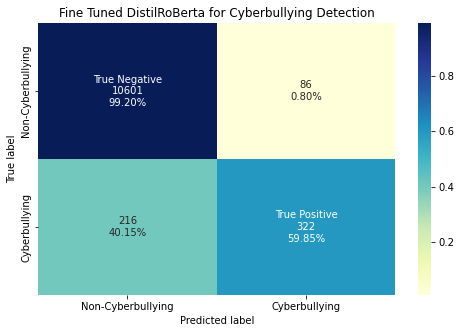

In [20]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive_binary/output_DistilRoBerta/holdout/checkpoint-101024', 
                        average_method='binary',
                        X_test=X_test)